## Burn Scar Analysis with PACE and EMIT Data

Author: Skye Caplan (NASA, SSAI)
Last updated: 02/25/2026

<div class="alert alert-info" role="alert">

An [Earthdata Login][edl] account is required to access data from the NASA Earthdata system, including NASA PACE and EMIT data.

</div>

[edl]: https://urs.earthdata.nasa.gov/
[oci-data-access]: https://oceancolor.gsfc.nasa.gov/resources/docs/tutorials/notebooks/oci_data_access/
[emit-data-access]: https://nasa.github.io/VITALS/python/Exploring_EMIT_L2A_RFL.html

## Summary

This notebook will use the data downloaded from `01_Colocate_PACE_EMIT_data.ipynb` and preprocessed from `02_Align_PACE_EMIT_Grids.ipynb` to calculate the difference in normalized burn ratio (dNBR) over Southern California in response to fires which occurred in January 2025. We will demonstrate the complementary nature of PACE and EMIT observations, and how we can use their different temporal and spatial resolutions to our advantage. 

## Learning Objectives

At the end of this notebook, you will know how to:
- FILL OUT

## Contents
1. [Setup](#1.-Setup)
2. [Preparing PACE Data](#2.-Preparing-PACE-Data)

## 1. Setup

Begin by importing all of the packages used in this notebook.

In [1]:
import xarray as xr 
import numpy as np 
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs 
import rioxarray as rio
import rasterio 
import cf_xarray 
import utils 
import emit_tools as et 
import cartopy
import earthaccess
from rasterio.enums import Resampling
from rasterio.crs import CRS

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In the previous notebook tutorial, `02_Align_PACE_EMIT_Grid.ipynb`, we gridded and subset several PACE and EMIT granules which we will use for this tutorial. If you haven't completed that notebook, please go through it before completing this one. If you have, you'll recall we exported the subset data to their own files so they can be used again. Replace the paths in the next cell with your path to the same files.

<div class="alert alert-warning" role="alert">

There's a better way to do this - provide the files? Write a fcn which downloads and preprocesses for them?

</div>

In [2]:
emit_paths = ["subset_data/emit_prefire.nc",
              "subset_data/emit_postfire.nc"]
oci_paths = [ "subset_data/oci_prefire.nc",
              "subset_data/oci_postfire.nc"]

emit_prefire = xr.open_dataset(emit_paths[0])
emit_postfire = xr.open_dataset(emit_paths[1])
oci_prefire = xr.open_dataset(oci_paths[0])
oci_postfire = xr.open_dataset(oci_paths[1])

### 2. Preparing Data for NBR
For this case study, we'll be investigating fires that occurred in January of 2025 in the Los Angeles area of Southern California using the Normalized Burn Ratio (NBR). NBR is a multispectral vegetation index that PACE does not put out as a product, but can be calculated with its surface reflectance bands using the equatiob below:
$$NBR = \frac{NIR - SWIR}{NIR+SWIR}$$

The difference in NBR (dNBR) in time can be used to delineate burn scars in an area. dNBR is calculated as $dNBR = NBR_{prefire} - NBR_{postfire}$

In the previous tutorials, we preprocessed pre- and post-fire data from both PACE and EMIT. Now that we have the data ready, we can proceed with calculating the index each sensor and time period. To do so, we'll select NIR and SWIR bands (870 nm and 2131 nm) and calculate NBR. 

In [3]:
emit_prefire = emit_prefire.sel({"wavelengths":[870, 2131]}, method="nearest")
emit_postfire = emit_postfire.sel({"wavelengths":[870, 2131]}, method="nearest")
oci_prefire = oci_prefire.sel({"wavelength_3d":[870, 2131]}, method="nearest")
oci_postfire = oci_postfire.sel({"wavelength_3d":[870, 2131]}, method="nearest")

To calculate dNBR and assess the burn scars and their extents in the area, subtract the postfire NBR from the prefire NBR as in the equation above. We've defined a function to do this:

In [48]:
def calc_nbr(ds, wvl_var=None):
    """
    Calculates Normalized Burn Ratio given reflectance data
    Args:
        ds - reflectance dataset with wavelength info as a coordinate
        wvl_var - str name of wavelength variable. Will attempt to find it if
                  none given
    Returns:
        nbr - NBR dataset
    """
    # Get wavelength dimension name for selection
    for dim in list(ds.dims):
        if "wavelength" in dim:
            wvl_var = dim
            break
        else:
            continue
    
    # Calculate NBR
    if wvl_var is None:
        print("Could not find wavelength variable, please provide the variable name in the function call")
        return None
    else:
        nir = ds.sel({f"{wvl_var}":870}, method="nearest")
        print(f"nir wv {nir[wvl_var].data}")
        swir = ds.sel({f"{wvl_var}":2131}, method="nearest")
        print(f"swir wv {swir[wvl_var].data}")
        nbr = ((nir - swir) / (nir + swir))
        # TODO: set attrs here too
        return xr.Dataset({"nbr":nbr})

In [49]:
oci_prefire_nbr = calc_nbr(oci_prefire.rhos)
oci_postfire_nbr = calc_nbr(oci_postfire.rhos)
emit_prefire_nbr = calc_nbr(emit_prefire.reflectance)
emit_postfire_nbr = calc_nbr(emit_postfire.reflectance)

nir wv 872.517578125
swir wv 2130.41748046875
nir wv 872.517578125
swir wv 2130.41748046875


Now calculate the dNBR

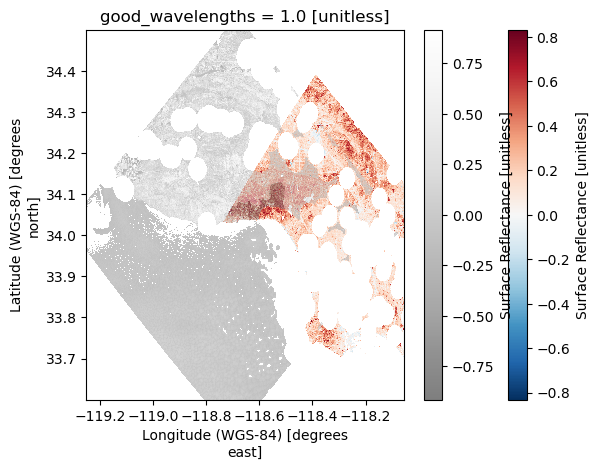

In [60]:
fig, ax = plt.subplots()
emit_prefire_nbr.nbr.plot()
emit_postfire_nbr.nbr.plot(cmap="Greys_r", alpha=0.5)


In [54]:
oci_dnbr = oci_prefire_nbr - oci_postfire_nbr
oci_dnbr = oci_dnbr.rename({"nbr":"dnbr"})
emit_dnbr = emit_prefire_nbr.nbr - emit_postfire_nbr.nbr
#emit_dnbr = emit_dnbr.rename({"nbr":"dnbr"})

In [62]:
emit_prefire_nbr

<xarray.Dataset> Size: 26MB
Dimensions:           (latitude: 1459, longitude: 2184)
Coordinates:
  * latitude          (latitude) float64 12kB 34.39 34.39 34.39 ... 33.6 33.6
  * longitude         (longitude) float64 17kB -118.9 -118.9 ... -117.8 -117.8
    elev              (latitude, longitude) float32 13MB nan nan nan ... nan nan
    good_wavelengths  float32 4B 1.0
Data variables:
    nbr               (latitude, longitude) float32 13MB nan nan nan ... nan nan

In [63]:
emit_postfire_nbr

<xarray.Dataset> Size: 29MB
Dimensions:           (latitude: 1659, longitude: 2203)
Coordinates:
  * latitude          (latitude) float64 13kB 34.5 34.5 34.5 ... 33.6 33.6 33.6
  * longitude         (longitude) float64 18kB -119.2 -119.2 ... -118.1 -118.1
    elev              (latitude, longitude) float32 15MB nan nan nan ... nan nan
    good_wavelengths  float32 4B 1.0
Data variables:
    nbr               (latitude, longitude) float32 15MB nan nan nan ... nan nan

TypeError: No numeric data to plot.

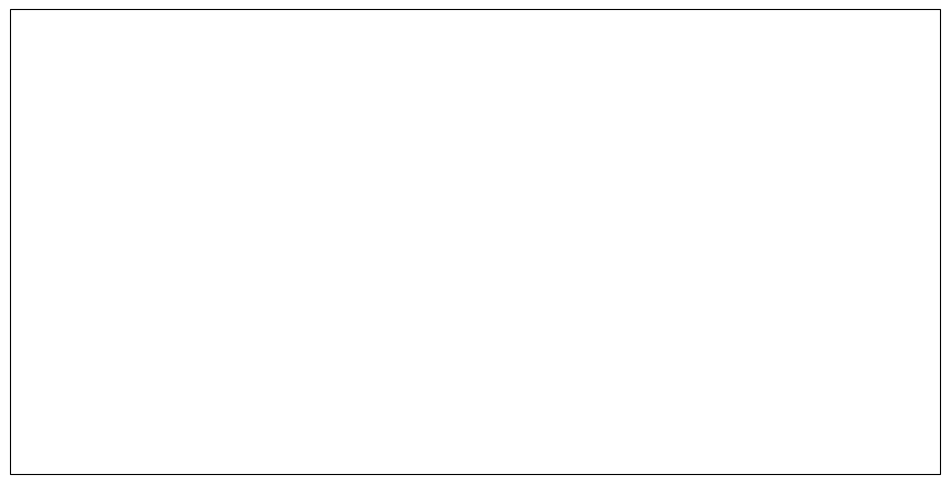

In [45]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(12, 7), subplot_kw={"projection": ccrs.PlateCarree()})
emit_dnbr.dnbr.plot(vmin=-0.4, vmax=1, cmap=sns.color_palette("vlag", as_cmap=True))
ax.gridlines(draw_labels={"left": "y", "bottom": "x"}, linewidth=0.25, alpha=0)
ax.coastlines(linewidth=0.5)
ax.set_facecolor('k')
#ax.set_extent([scene[0],scene[2],scene[1],scene[3]], crs=ccrs.PlateCarree())
ax.set_title("dNBR")
plt.show()

In [6]:
# Downloading here for now, just one EMIT gran
results = earthaccess.search_data(
        short_name=["EMITL2ARFL"],
        granule_name="*20250324T220953*", 
    )
for item in results:
    display(item)

# Downloading only the rfl for now, but maybe we want the mask too?
#paths = earthaccess.download(results[0].data_links(access="external")[0], local_path="data")
#paths = earthaccess.download(results, local_path="data")


Collection: {'ShortName': 'EMITL2ARFL', 'Version': '001'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -118.55077362060547, 'Latitude': 34.642295837402344}, {'Longitude': -119.3215560913086, 'Latitude': 34.02610778808594}, {'Longitude': -118.82703399658203, 'Latitude': 33.40751647949219}, {'Longitude': -118.0562515258789, 'Latitude': 34.023704528808594}, {'Longitude': -118.55077362060547, 'Latitude': 34.642295837402344}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2025-03-24T22:09:53Z', 'EndingDateTime': '2025-03-24T22:10:05Z'}}
Size(MB): 3579.960346221924
Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20250324T220953_2508314_003/EMIT_L2A_RFL_001_20250324T220953_2508314_003.nc', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20250324T220953_2508314_003/EMIT_L2A_RFLUNCERT_001_20250324T220953_2508314_003.nc', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20250324T220953_2508314_003/EMIT_L2A_MASK_001_20250324T220953_2508314_003.nc']

In [7]:
paths = earthaccess.download(results[0].data_links(access="external")[2], local_path="data")

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]